Using device: cuda
Training on times: [15.0, 30.0, 45.0] seconds
Predicting time: 60.0 seconds
Input tensor shape: torch.Size([1, 12, 256, 256])
Target tensor shape: torch.Size([1, 4, 256, 256])


/tmp/ipykernel_36/2167700632.py:155: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset('/kaggle/input/pr1-rbc-sim-data/RBC_Output.nc')


Total parameters in Multi-Variable FNO: 33,593,412
Starting Multi-Variable FNO training...
Epoch 0/2000 | Total: 47.474102 | Physics: 0.528352 | BC: 0.235510 | Data: 3.516968 | LR: 0.000040
Epoch 100/2000 | Total: 3.134826 | Physics: 0.242002 | BC: 0.004645 | Data: 0.265210 | LR: 0.000531
Epoch 200/2000 | Total: 0.342802 | Physics: 0.100986 | BC: 0.001331 | Data: 0.016469 | LR: 0.001000
Epoch 300/2000 | Total: 0.126726 | Physics: 0.035780 | BC: 0.000951 | Data: 0.003244 | LR: 0.000992
Epoch 400/2000 | Total: 0.159096 | Physics: 0.024615 | BC: 0.001356 | Data: 0.005574 | LR: 0.000969
Epoch 500/2000 | Total: 0.121220 | Physics: 0.014273 | BC: 0.001295 | Data: 0.003124 | LR: 0.000932
Epoch 600/2000 | Total: 0.107097 | Physics: 0.013149 | BC: 0.001115 | Data: 0.002724 | LR: 0.000882
Epoch 700/2000 | Total: 0.098411 | Physics: 0.012341 | BC: 0.001004 | Data: 0.002490 | LR: 0.000820
Epoch 800/2000 | Total: 0.111719 | Physics: 0.016231 | BC: 0.001138 | Data: 0.002761 | LR: 0.000748
Epoch 900/

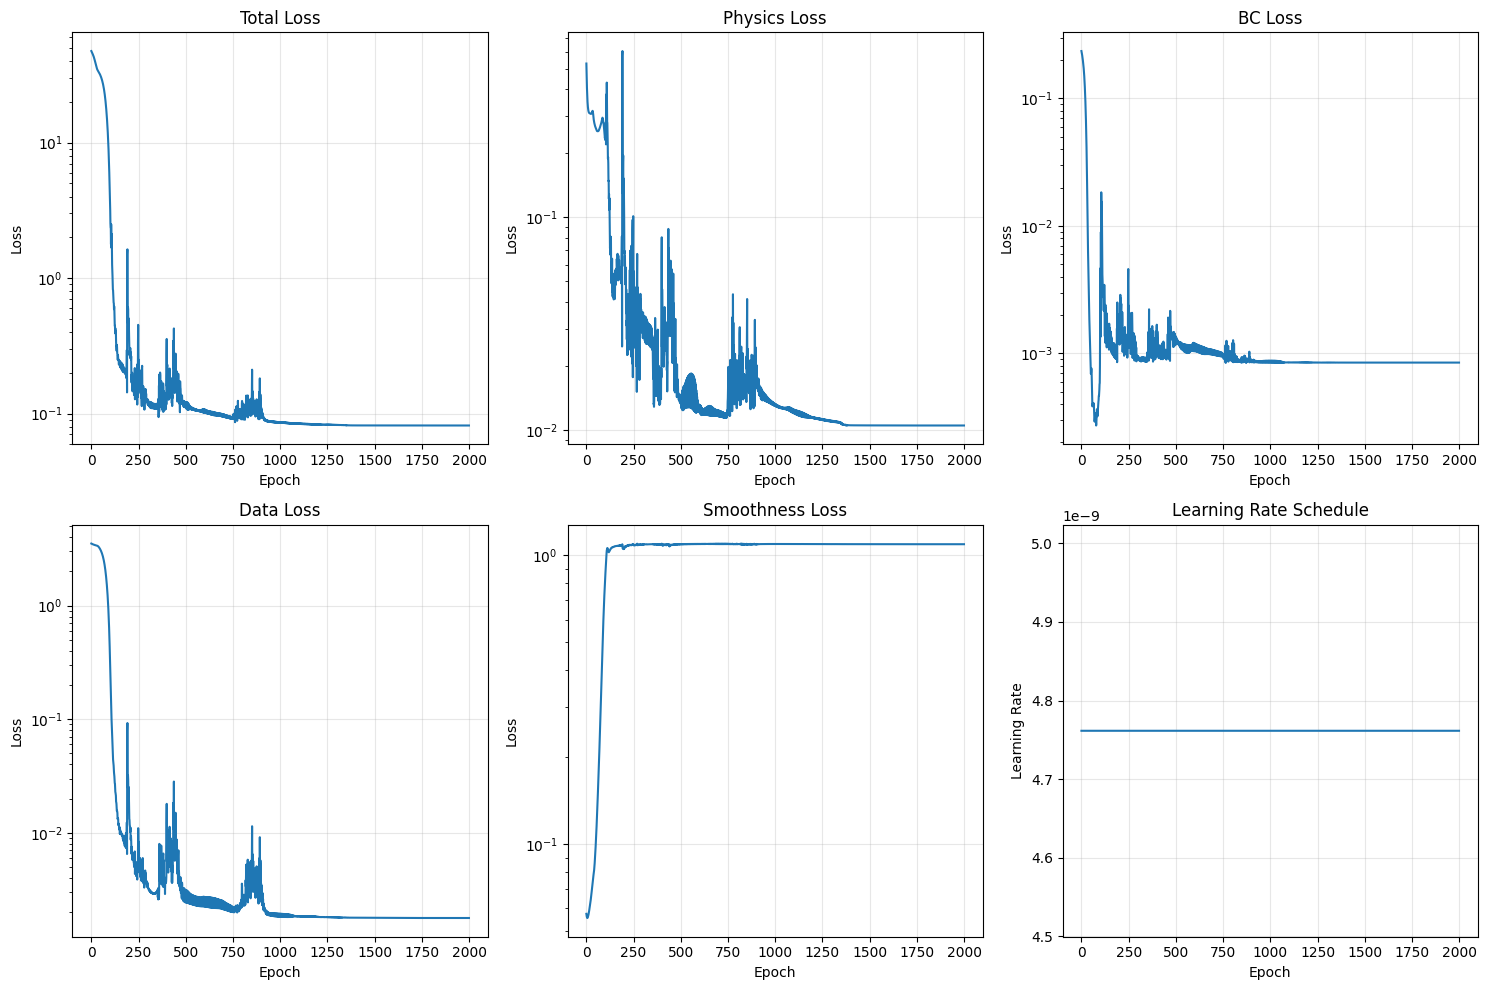

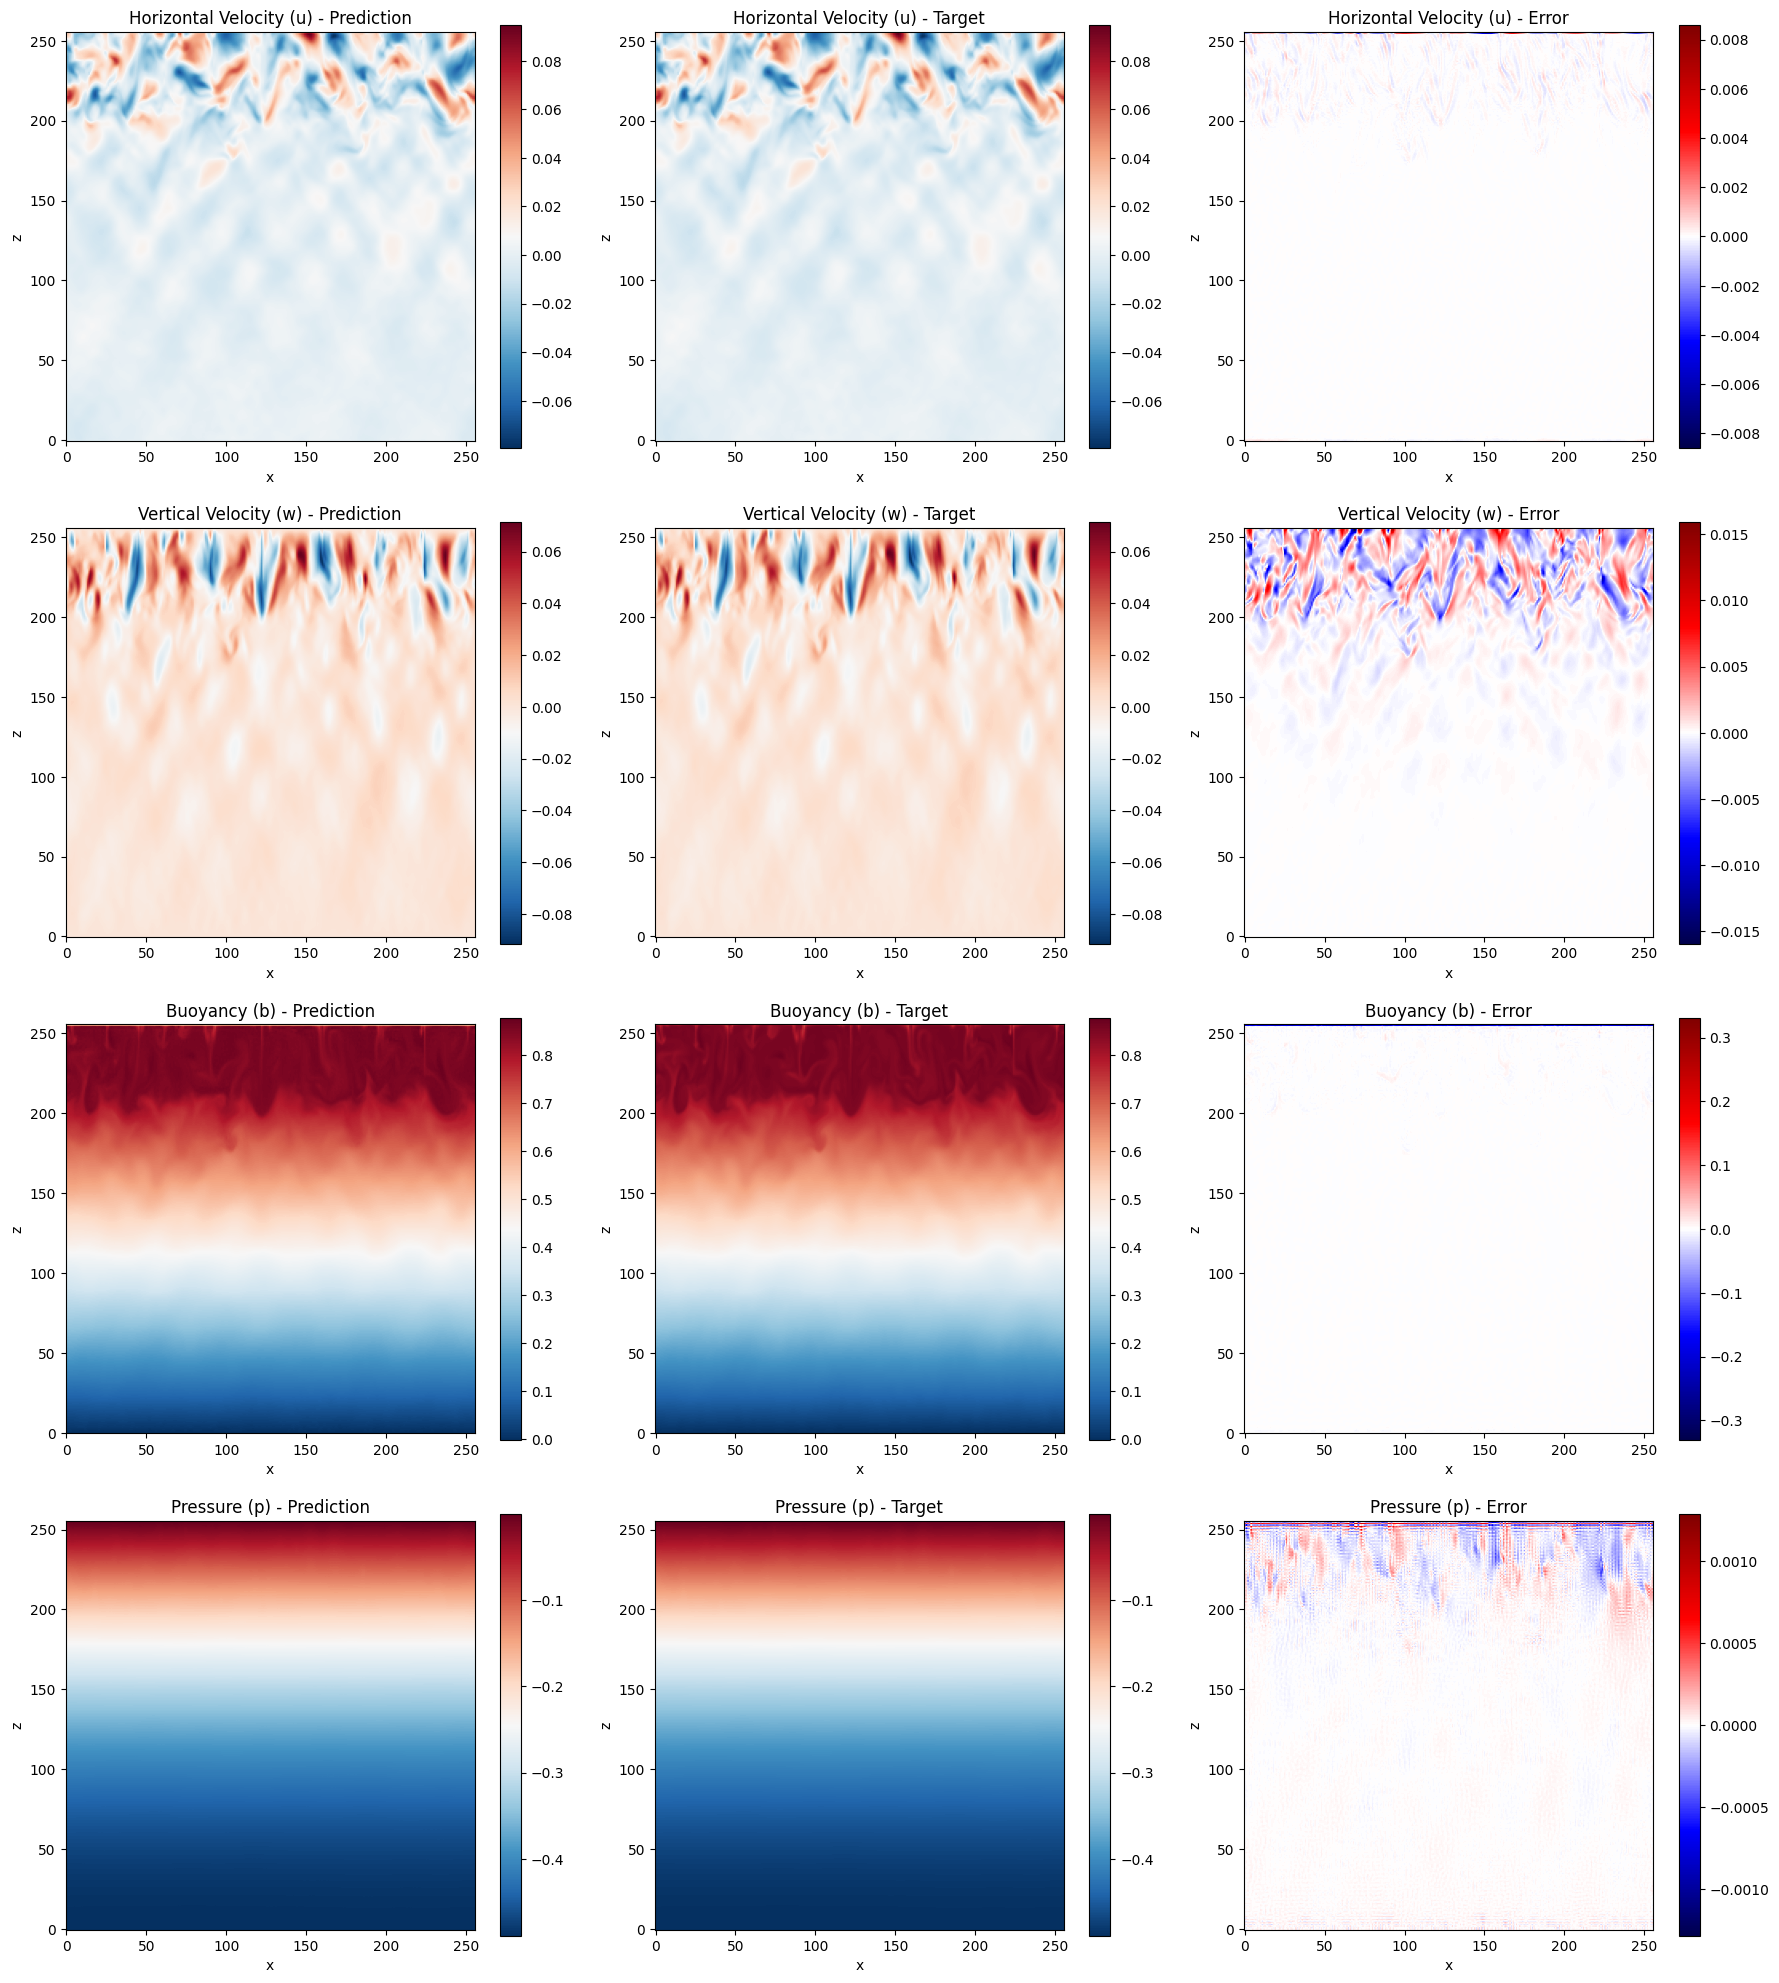


Error Metrics for All Variables:
--------------------------------------------------

Horizontal Velocity (u):
  MSE: 0.000000
  MAE: 0.000046
  Max Error: 0.008576
  Relative Error: 3.5199%

Vertical Velocity (w):
  MSE: 0.000002
  MAE: 0.000543
  Max Error: 0.015959
  Relative Error: 906.3994%

Buoyancy (b):
  MSE: 0.000351
  MAE: 0.001843
  Max Error: 0.330792
  Relative Error: 0.9280%

Pressure (p):
  MSE: 0.000000
  MAE: 0.000035
  Max Error: 0.001285
  Relative Error: 0.2913%


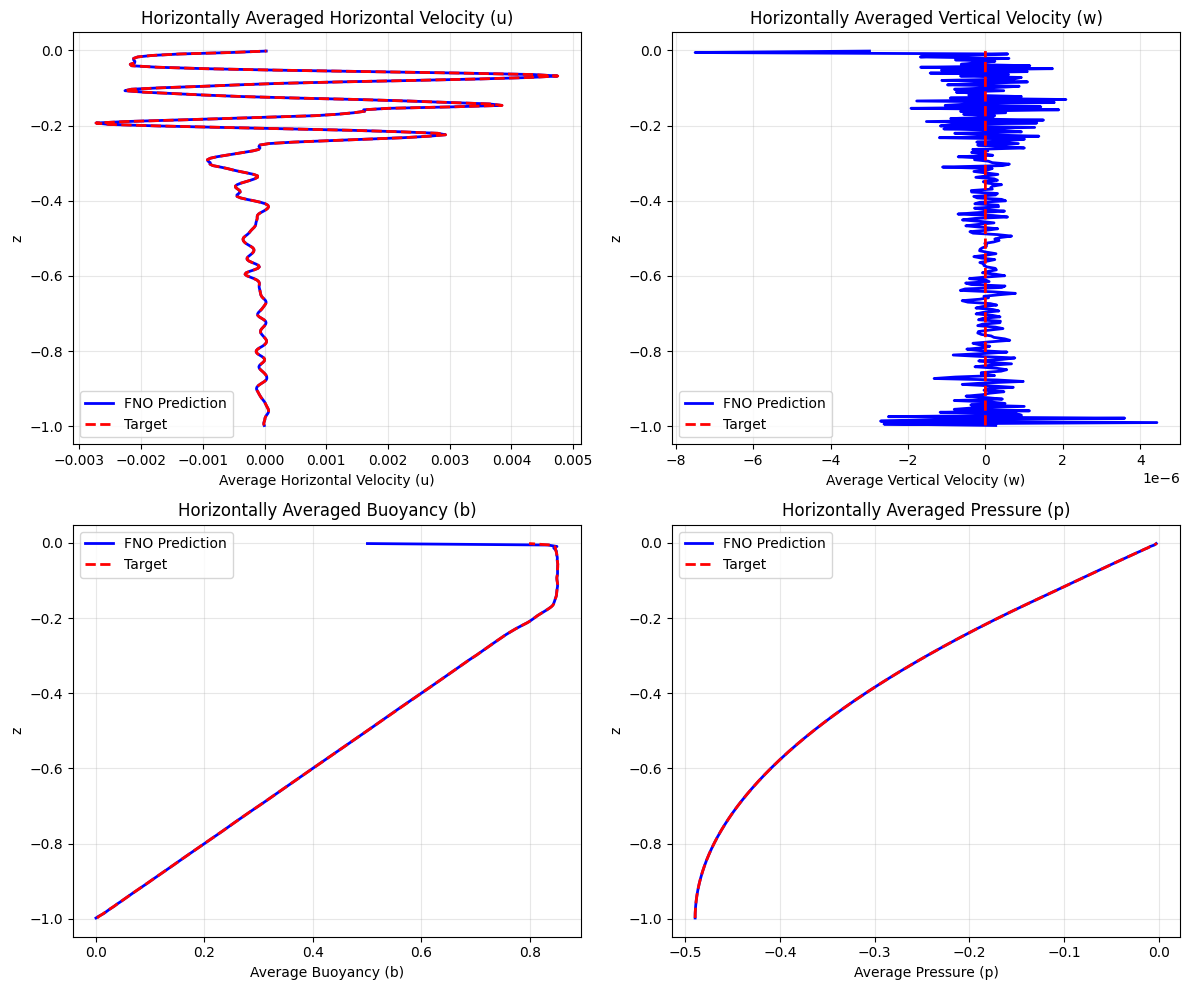


Integral Quantities:
--------------------------------------------------
Kinetic Energy - Predicted: 0.000143, Target: 0.000144, Error: 0.65%
Enstrophy - Predicted: 0.399696, Target: 0.401567, Error: 0.47%


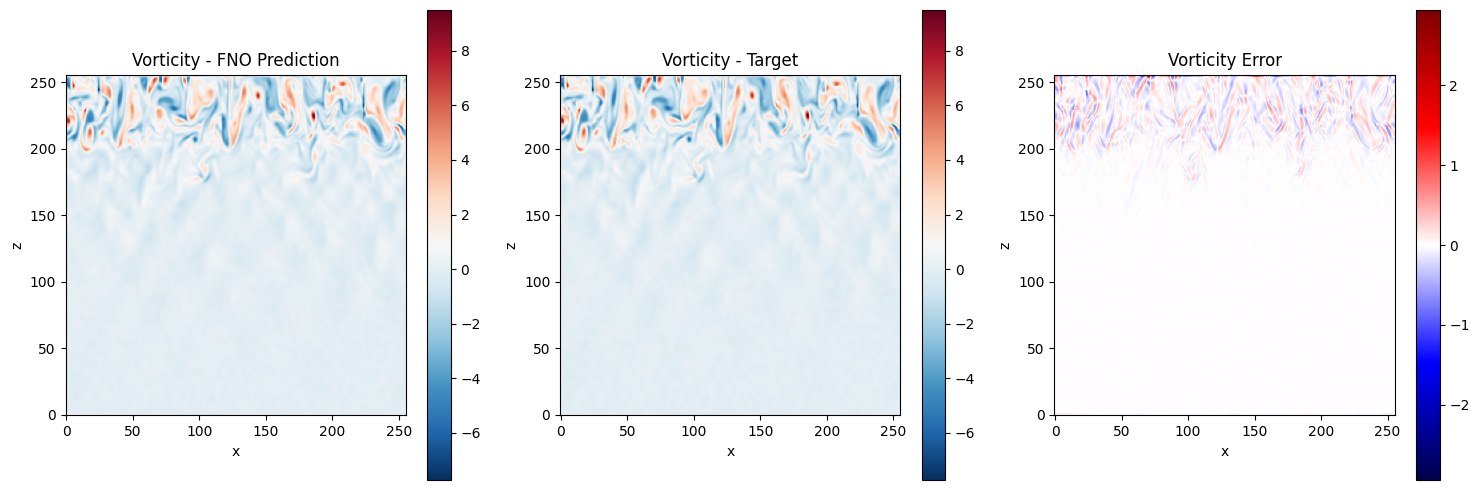


Multi-step Prediction Capability:
--------------------------------------------------
Predicted state at t=120
Predicted state at t=150 (extrapolation)


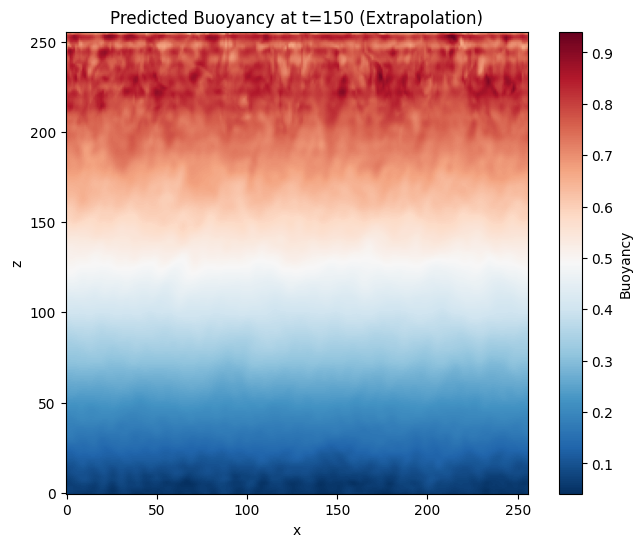


Model saved successfully!


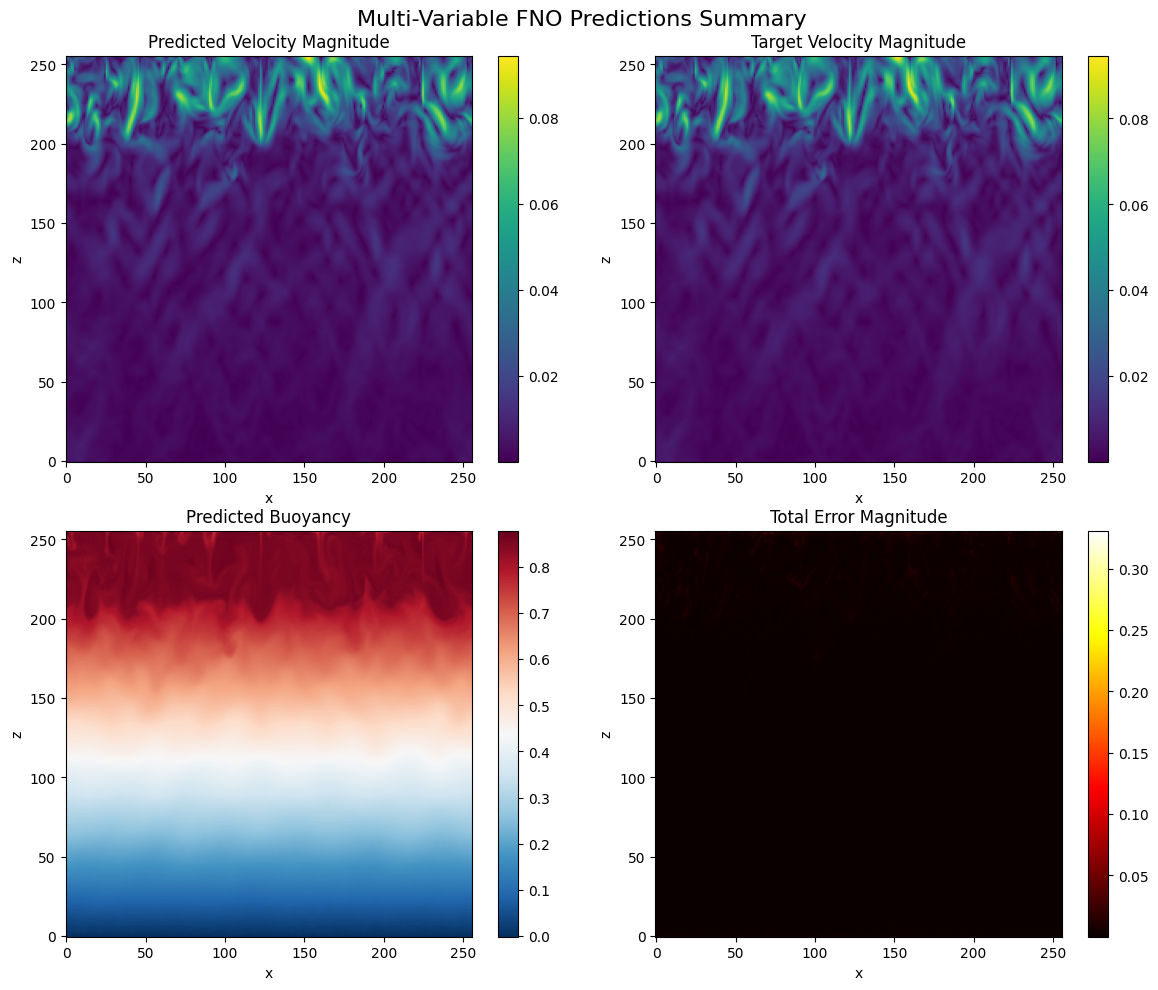


Training completed successfully!
Final best loss: 0.081564


In [ ]:
#==================================
# BLOCK 1 - Complete FNO Implementation with All Components
#==================================

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import xarray as xr
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.fft import rfft2, irfft2

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

#==================================
# BLOCK 2 - Core FNO Components
#==================================

class SpectralConv2d(nn.Module):
    """2D Fourier layer. Performs FFT, linear transform, and Inverse FFT."""
    
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  # Number of Fourier modes to keep in x
        self.modes2 = modes2  # Number of Fourier modes to keep in z
        
        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        
    def compl_mul2d(self, input, weights):
        # Complex multiplication
        return torch.einsum("bixy,ioxy->boxy", input, weights)
    
    def forward(self, x):
        batchsize = x.shape[0]
        
        # Compute Fourier coefficients
        x_ft = rfft2(x)
        
        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        
        # Top-left corner (low frequencies)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        
        # Bottom-left corner (high frequencies in z, low in x)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)
        
        # Return to physical space
        x = irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class FNOBlock(nn.Module):
    """Basic FNO block with spectral convolution and skip connection"""
    
    def __init__(self, in_channels, out_channels, modes1, modes2, activation='gelu'):
        super(FNOBlock, self).__init__()
        self.conv = SpectralConv2d(in_channels, out_channels, modes1, modes2)
        self.w = nn.Conv2d(in_channels, out_channels, 1)
        self.bn = nn.BatchNorm2d(out_channels)
        
        if activation == 'gelu':
            self.activation = nn.GELU()
        elif activation == 'relu':
            self.activation = nn.ReLU()
        else:
            self.activation = nn.Identity()
    
    def forward(self, x):
        x1 = self.conv(x)
        x2 = self.w(x)
        x = self.bn(x1 + x2)
        x = self.activation(x)
        return x

#==================================
# BLOCK 3 - Multi-Variable FNO Model
#==================================

class MultiVariableFNO2d(nn.Module):
    """
    FNO for predicting multiple variables (u, w, b, p) simultaneously
    Takes previous states as input and predicts the next state
    """
    
    def __init__(self, modes1=24, modes2=24, width=64, n_vars=4, n_layers=4):
        super(MultiVariableFNO2d, self).__init__()
        
        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.n_vars = n_vars  # u, w, b, p
        self.n_layers = n_layers
        
        # Input: n_vars channels per time step
        in_channels = n_vars * 3  # 3 time steps
        
        # Input projection
        self.fc0 = nn.Sequential(
            nn.Conv2d(in_channels, width, 1),
            nn.GELU(),
            nn.Conv2d(width, width, 1),
        )
        
        # FNO layers
        self.fno_blocks = nn.ModuleList([
            FNOBlock(width, width, modes1, modes2, activation='gelu')
            for _ in range(n_layers)
        ])
        
        # Output projection for all variables
        self.fc1 = nn.Sequential(
            nn.Conv2d(width, 128, 1),
            nn.GELU(),
            nn.Conv2d(128, 64, 1),
            nn.GELU(),
            nn.Conv2d(64, n_vars, 1)  # Output all variables
        )
        
    def forward(self, x):
        # x shape: (batch, channels, height, width)
        # channels = n_vars * n_timesteps
        
        # Lift to higher dimension
        x = self.fc0(x)
        
        # Apply FNO blocks
        for fno in self.fno_blocks:
            x = fno(x)
        
        # Project to output (all variables)
        x = self.fc1(x)
        
        return x  # (batch, n_vars, height, width)

#==================================
# BLOCK 4 - Data Loading and Preprocessing
#==================================

# Load data
ds = xr.open_dataset('/kaggle/input/pr1-rbc-sim-data/RBC_Output.nc')

# Select training time steps
train_times = [30, 60, 90]  # Input times
target_time = 120  # Target time to predict

# Fixed time step
dt = 30.0  # Time difference between consecutive snapshots

# Extract fields for all time steps
def extract_fields_at_time(ds, time_idx):
    """Extract all fields at a given time index"""
    data = ds.isel(time=time_idx)
    return {
        'u': data['u'].values,
        'w': data['w'].values,
        'b': data['b'].values,
        'p_dyn': data['p_dyn'].values,
        'time': float(data['time'].values) / 1e9  # Convert to seconds
    }

# Get training data
train_data = [extract_fields_at_time(ds, t) for t in train_times]
target_data = extract_fields_at_time(ds, target_time)

print(f"Training on times: {[d['time'] for d in train_data]} seconds")
print(f"Predicting time: {target_data['time']} seconds")

# Interpolation function
def interpolate_to_common_grid(field, target_shape=(256, 256)):
    if field.shape == target_shape:
        return field
    field_tensor = torch.from_numpy(field).float().unsqueeze(0).unsqueeze(0)
    interpolated = F.interpolate(field_tensor, size=target_shape, mode='bilinear', align_corners=True)
    return interpolated.squeeze().numpy()

# Normalize fields
def normalize_field(field):
    mean = np.mean(field)
    std = np.std(field) + 1e-8
    return (field - mean) / std, mean, std

# Process all training data
processed_train_data = []
norm_params = {'u': None, 'w': None, 'b': None, 'p': None}

for i, data in enumerate(train_data):
    processed = {}
    
    # Interpolate all fields to common grid
    u_interp = interpolate_to_common_grid(data['u'])
    w_interp = interpolate_to_common_grid(data['w'])
    p_interp = interpolate_to_common_grid(data['p_dyn'])
    
    # Use normalization from first timestep for consistency
    if i == 0:
        u_norm, u_mean, u_std = normalize_field(u_interp)
        w_norm, w_mean, w_std = normalize_field(w_interp)
        b_norm, b_mean, b_std = normalize_field(data['b'])
        p_norm, p_mean, p_std = normalize_field(p_interp)
        
        norm_params['u'] = (u_mean, u_std)
        norm_params['w'] = (w_mean, w_std)
        norm_params['b'] = (b_mean, b_std)
        norm_params['p'] = (p_mean, p_std)
    else:
        # Apply existing normalization
        u_norm = (u_interp - norm_params['u'][0]) / norm_params['u'][1]
        w_norm = (w_interp - norm_params['w'][0]) / norm_params['w'][1]
        b_norm = (data['b'] - norm_params['b'][0]) / norm_params['b'][1]
        p_norm = (p_interp - norm_params['p'][0]) / norm_params['p'][1]
    
    processed['u'] = u_norm
    processed['w'] = w_norm
    processed['b'] = b_norm
    processed['p'] = p_norm
    
    processed_train_data.append(processed)

# Process target data
u_target_interp = interpolate_to_common_grid(target_data['u'])
w_target_interp = interpolate_to_common_grid(target_data['w'])
p_target_interp = interpolate_to_common_grid(target_data['p_dyn'])

target_processed = {
    'u': (u_target_interp - norm_params['u'][0]) / norm_params['u'][1],
    'w': (w_target_interp - norm_params['w'][0]) / norm_params['w'][1],
    'b': (target_data['b'] - norm_params['b'][0]) / norm_params['b'][1],
    'p': (p_target_interp - norm_params['p'][0]) / norm_params['p'][1]
}

# Stack input data: [u1, w1, b1, p1, u2, w2, b2, p2, u3, w3, b3, p3]
input_channels = []
for data in processed_train_data:
    input_channels.extend([data['u'], data['w'], data['b'], data['p']])

input_tensor = torch.FloatTensor(np.stack(input_channels, axis=0)).unsqueeze(0).to(device)

# Stack target data: [u_target, w_target, b_target, p_target]
target_tensor = torch.FloatTensor(np.stack([
    target_processed['u'],
    target_processed['w'],
    target_processed['b'],
    target_processed['p']
], axis=0)).unsqueeze(0).to(device)

print(f"Input tensor shape: {input_tensor.shape}")
print(f"Target tensor shape: {target_tensor.shape}")

# Grid parameters
x_coords = ds.x_caa.values
z_coords = ds.z_aac.values
dx = float(x_coords[1] - x_coords[0])
dz = float(z_coords[1] - z_coords[0])
kappa = 1e-6

#==================================
# Continue with the rest of the code from BLOCK 4 onwards...
#==================================

# [Include all the remaining blocks from my previous response, starting from the physics loss functions]
#==================================
# BLOCK 4 - Physics-Informed Loss Functions
#==================================

def compute_derivatives_multi(fields, dx, dz):
    """Compute spatial derivatives for multiple fields"""
    if fields.dim() == 3:
        fields = fields.unsqueeze(0)
    
    batch_size, n_vars, height, width = fields.shape
    
    # Pad for periodic BC in x
    fields_padded_x = F.pad(fields, (1, 1, 0, 0), mode='circular')
    df_dx = (fields_padded_x[:, :, :, 2:] - fields_padded_x[:, :, :, :-2]) / (2 * dx)
    
    # z-derivatives
    df_dz = torch.zeros_like(fields)
    df_dz[:, :, 1:-1, :] = (fields[:, :, 2:, :] - fields[:, :, :-2, :]) / (2 * dz)
    df_dz[:, :, 0, :] = (fields[:, :, 1, :] - fields[:, :, 0, :]) / dz
    df_dz[:, :, -1, :] = (fields[:, :, -1, :] - fields[:, :, -2, :]) / dz
    
    return df_dx, df_dz

def physics_loss_multi(pred_norm, prev_states_norm, dx, dz, dt, kappa, norm_params):
    """
    Physics loss for multiple variables
    pred_norm: (batch, 4, H, W) - [u, w, b, p] at target time
    prev_states_norm: list of previous states
    """
    # Extract predicted variables (normalized)
    u_pred_norm = pred_norm[:, 0]
    w_pred_norm = pred_norm[:, 1]
    b_pred_norm = pred_norm[:, 2]
    p_pred_norm = pred_norm[:, 3]
    
    # Get last state for time derivative
    last_state = prev_states_norm[-1]
    u_last_norm = last_state['u']
    w_last_norm = last_state['w']
    b_last_norm = last_state['b']
    
    # Denormalize for physics calculations
    u_pred = u_pred_norm * norm_params['u'][1] + norm_params['u'][0]
    w_pred = w_pred_norm * norm_params['w'][1] + norm_params['w'][0]
    b_pred = b_pred_norm * norm_params['b'][1] + norm_params['b'][0]
    p_pred = p_pred_norm * norm_params['p'][1] + norm_params['p'][0]
    
    u_last = u_last_norm * norm_params['u'][1] + norm_params['u'][0]
    w_last = w_last_norm * norm_params['w'][1] + norm_params['w'][0]
    b_last = b_last_norm * norm_params['b'][1] + norm_params['b'][0]
    
    # Convert to tensors if needed
    if isinstance(u_last, np.ndarray):
        u_last = torch.FloatTensor(u_last).to(device)
        w_last = torch.FloatTensor(w_last).to(device)
        b_last = torch.FloatTensor(b_last).to(device)
    
    # Compute derivatives
    all_fields = torch.stack([u_pred, w_pred, b_pred, p_pred], dim=1)
    df_dx, df_dz = compute_derivatives_multi(all_fields, dx, dz)
    
    du_dx = df_dx[:, 0]
    dw_dx = df_dx[:, 1]
    db_dx = df_dx[:, 2]
    dp_dx = df_dx[:, 3]
    
    du_dz = df_dz[:, 0]
    dw_dz = df_dz[:, 1]
    db_dz = df_dz[:, 2]
    dp_dz = df_dz[:, 3]
    
    # Second derivatives for diffusion
    d2u_dx2, _ = compute_derivatives_multi(du_dx.unsqueeze(1), dx, dz)
    _, d2u_dz2 = compute_derivatives_multi(du_dz.unsqueeze(1), dx, dz)
    d2w_dx2, _ = compute_derivatives_multi(dw_dx.unsqueeze(1), dx, dz)
    _, d2w_dz2 = compute_derivatives_multi(dw_dz.unsqueeze(1), dx, dz)
    d2b_dx2, _ = compute_derivatives_multi(db_dx.unsqueeze(1), dx, dz)
    _, d2b_dz2 = compute_derivatives_multi(db_dz.unsqueeze(1), dx, dz)
    
    d2u_dx2 = d2u_dx2.squeeze(1)
    d2u_dz2 = d2u_dz2.squeeze(1)
    d2w_dx2 = d2w_dx2.squeeze(1)
    d2w_dz2 = d2w_dz2.squeeze(1)
    d2b_dx2 = d2b_dx2.squeeze(1)
    d2b_dz2 = d2b_dz2.squeeze(1)
    
    # Time derivatives
    du_dt = (u_pred - u_last) / dt
    dw_dt = (w_pred - w_last) / dt
    db_dt = (b_pred - b_last) / dt
    
    # Physics residuals
    # Momentum equation (u)
    u_residual = du_dt + u_pred * du_dx + w_pred * du_dz + dp_dx - kappa * (d2u_dx2 + d2u_dz2)
    
    # Momentum equation (w)
    w_residual = dw_dt + u_pred * dw_dx + w_pred * dw_dz + dp_dz - kappa * (d2w_dx2 + d2w_dz2) - b_pred
    
    # Continuity equation
    continuity_residual = du_dx + dw_dz
    
    # Buoyancy equation
    b_residual = db_dt + u_pred * db_dx + w_pred * db_dz - kappa * (d2b_dx2 + d2b_dz2)
    
    # Combine losses
    loss = (torch.mean(u_residual**2) + 
            torch.mean(w_residual**2) + 
            torch.mean(continuity_residual**2) + 
            torch.mean(b_residual**2))
    
    return loss

def boundary_loss_multi(pred_norm, norm_params):
    """Boundary condition loss for all variables"""
    # Extract variables
    u_pred_norm = pred_norm[:, 0]
    w_pred_norm = pred_norm[:, 1]
    b_pred_norm = pred_norm[:, 2]
    
    # Denormalize
    u_pred = u_pred_norm * norm_params['u'][1] + norm_params['u'][0]
    w_pred = w_pred_norm * norm_params['w'][1] + norm_params['w'][0]
    b_pred = b_pred_norm * norm_params['b'][1] + norm_params['b'][0]
    
    # Velocity BCs (no-slip at top and bottom)
    u_top_bc = torch.mean(u_pred[:, -1, :]**2)
    u_bottom_bc = torch.mean(u_pred[:, 0, :]**2)
    w_top_bc = torch.mean(w_pred[:, -1, :]**2)
    w_bottom_bc = torch.mean(w_pred[:, 0, :]**2)
    
    # Buoyancy BCs
    b_top_bc = torch.mean((b_pred[:, -1, :] - 0.5)**2)
    b_bottom_bc = torch.mean(b_pred[:, 0, :]**2)
    
    return u_top_bc + u_bottom_bc + w_top_bc + w_bottom_bc + b_top_bc + b_bottom_bc

def smoothness_loss_multi(pred):
    """Total variation regularization for all variables"""
    tv_loss = 0
    for i in range(pred.shape[1]):  # For each variable
        field = pred[:, i]
        tv_z = torch.mean(torch.abs(field[:, 1:, :] - field[:, :-1, :]))
        tv_x = torch.mean(torch.abs(field[:, :, 1:] - field[:, :, :-1]))
        tv_loss += tv_z + tv_x
    return tv_loss

#==================================
# BLOCK 5 - Model Initialization and Training Setup
#==================================

# Initialize model
model = MultiVariableFNO2d(
    modes1=32,
    modes2=32,
    width=64,
    n_vars=4,  # u, w, b, p
    n_layers=4
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters in Multi-Variable FNO: {total_params:,}")

# Optimizer and scheduler
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-3,
    epochs=2000,
    steps_per_epoch=1,
    pct_start=0.1,
    anneal_strategy='cos'
)

# Loss weights
loss_weights = {
    'physics': 1.0,
    'bc': 50.0,
    'data': 10.0,
    'smooth': 0.01
}

#==================================
# BLOCK 6 - Training Loop
#==================================

# Training history
history = {
    'total_loss': [],
    'physics_loss': [],
    'bc_loss': [],
    'data_loss': [],
    'smooth_loss': []
}

# Training
model.train()
n_epochs = 2000
print_interval = 100

print("Starting Multi-Variable FNO training...")
best_loss = float('inf')

for epoch in range(n_epochs):
    optimizer.zero_grad()
    
    # Forward pass
    pred_norm = model(input_tensor)
    
    # Compute losses
    l_physics = physics_loss_multi(
        pred_norm, processed_train_data, dx, dz, dt, kappa, norm_params
    )
    
    l_bc = boundary_loss_multi(pred_norm, norm_params)
    
    # Data fitting loss
    l_data = torch.mean((pred_norm - target_tensor)**2)
    
    l_smooth = smoothness_loss_multi(pred_norm)
    
    # Total loss
    total_loss = (
        loss_weights['physics'] * l_physics +
        loss_weights['bc'] * l_bc +
        loss_weights['data'] * l_data +
        loss_weights['smooth'] * l_smooth
    )
    
    # Backward pass
    total_loss.backward()
    
    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
    optimizer.step()
    scheduler.step()
    
    # Record history
    history['total_loss'].append(total_loss.item())
    history['physics_loss'].append(l_physics.item())
    history['bc_loss'].append(l_bc.item())
    history['data_loss'].append(l_data.item())
    history['smooth_loss'].append(l_smooth.item())
    
    # Adaptive weight adjustment
    if epoch > 500 and epoch % 200 == 0:
        if l_physics.item() > 0.1:
            loss_weights['physics'] = min(loss_weights['physics'] * 1.2, 10.0)
        if l_bc.item() > 0.01:
            loss_weights['bc'] = min(loss_weights['bc'] * 1.1, 100.0)
    
    # Save best model
    if total_loss.item() < best_loss:
        best_loss = total_loss.item()
        best_model_state = model.state_dict().copy()
    
    # Print progress
    if epoch % print_interval == 0 or epoch == n_epochs - 1:
        print(f"Epoch {epoch}/{n_epochs} | Total: {total_loss.item():.6f} | "
              f"Physics: {l_physics.item():.6f} | BC: {l_bc.item():.6f} | "
              f"Data: {l_data.item():.6f} | LR: {scheduler.get_last_lr()[0]:.6f}")

# Load best model
model.load_state_dict(best_model_state)

#==================================
# BLOCK 7 - Plot Training History
#==================================

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

loss_names = ['total_loss', 'physics_loss', 'bc_loss', 'data_loss', 'smooth_loss']
loss_titles = ['Total Loss', 'Physics Loss', 'BC Loss', 'Data Loss', 'Smoothness Loss']

for idx, (loss_name, title) in enumerate(zip(loss_names, loss_titles)):
    ax = axes[idx]
    ax.semilogy(history[loss_name])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(title)
    ax.grid(True, alpha=0.3)

# Learning rate schedule
ax = axes[5]
lrs = [scheduler.get_last_lr()[0] for _ in range(len(history['total_loss']))]
ax.plot(lrs)
ax.set_xlabel('Epoch')
ax.set_ylabel('Learning Rate')
ax.set_title('Learning Rate Schedule')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#==================================
# BLOCK 8 - Evaluation and Visualization
#==================================

# Make predictions
model.eval()
with torch.no_grad():
    pred_norm = model(input_tensor)
    pred_norm = pred_norm.squeeze().cpu().numpy()

# Denormalize predictions
predictions = {
    'u': pred_norm[0] * norm_params['u'][1] + norm_params['u'][0],
    'w': pred_norm[1] * norm_params['w'][1] + norm_params['w'][0],
    'b': pred_norm[2] * norm_params['b'][1] + norm_params['b'][0],
    'p': pred_norm[3] * norm_params['p'][1] + norm_params['p'][0]
}

# Get actual target values (denormalized)
targets = {
    'u': target_data['u'][:, :256] if target_data['u'].shape[1] > 256 else target_data['u'],
    'w': target_data['w'][:256, :] if target_data['w'].shape[0] > 256 else target_data['w'],
    'b': target_data['b'],
    'p': target_data['p_dyn']
}

# Create comprehensive visualization
fig, axes = plt.subplots(4, 3, figsize=(18, 20))

variables = ['u', 'w', 'b', 'p']
var_names = ['Horizontal Velocity (u)', 'Vertical Velocity (w)', 'Buoyancy (b)', 'Pressure (p)']

for i, (var, var_name) in enumerate(zip(variables, var_names)):
    pred = predictions[var]
    target = targets[var]
    
    # Ensure same shape
    if pred.shape != target.shape:
        if var in ['u', 'p']:
            target = interpolate_to_common_grid(target)
        elif var == 'w':
            target = interpolate_to_common_grid(target)
    
    # Common colorbar limits
    vmin = min(pred.min(), target.min())
    vmax = max(pred.max(), target.max())
    
    # Prediction
    im1 = axes[i, 0].imshow(pred, aspect='equal', cmap='RdBu_r',
                           vmin=vmin, vmax=vmax, origin='lower')
    axes[i, 0].set_title(f'{var_name} - Prediction')
    axes[i, 0].set_xlabel('x')
    axes[i, 0].set_ylabel('z')
    plt.colorbar(im1, ax=axes[i, 0])
    
    # Target
    im2 = axes[i, 1].imshow(target, aspect='equal', cmap='RdBu_r',
                           vmin=vmin, vmax=vmax, origin='lower')
    axes[i, 1].set_title(f'{var_name} - Target')
    axes[i, 1].set_xlabel('x')
    axes[i, 1].set_ylabel('z')
    plt.colorbar(im2, ax=axes[i, 1])
    
    # Difference
    diff = pred - target
    im3 = axes[i, 2].imshow(diff, aspect='equal', cmap='seismic',
                           vmin=-np.abs(diff).max(), vmax=np.abs(diff).max(),
                           origin='lower')
    axes[i, 2].set_title(f'{var_name} - Error')
    axes[i, 2].set_xlabel('x')
    axes[i, 2].set_ylabel('z')
    plt.colorbar(im3, ax=axes[i, 2])

plt.tight_layout()
plt.show()

# Calculate error metrics for all variables
print("\nError Metrics for All Variables:")
print("-" * 50)

for var, var_name in zip(variables, var_names):
    pred = predictions[var]
    target = targets[var]
    
    # Ensure same shape for comparison
    if pred.shape != target.shape:
        target = interpolate_to_common_grid(target)
    
    mse = np.mean((pred - target)**2)
    mae = np.mean(np.abs(pred - target))
    max_error = np.max(np.abs(pred - target))
    rel_error = np.mean(np.abs(pred - target) / (np.abs(target) + 1e-8))
    
    print(f"\n{var_name}:")
    print(f"  MSE: {mse:.6f}")
    print(f"  MAE: {mae:.6f}")
    print(f"  Max Error: {max_error:.6f}")
    print(f"  Relative Error: {rel_error:.4%}")

#==================================
# BLOCK 9 - Additional Analysis and Visualizations
#==================================

# Plot horizontally averaged profiles
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, (var, var_name) in enumerate(zip(variables, var_names)):
    ax = axes[idx]
    
    pred = predictions[var]
    target = targets[var]
    
    if pred.shape != target.shape:
        target = interpolate_to_common_grid(target)
    
    # Compute horizontal averages
    avg_pred = np.mean(pred, axis=1)
    avg_target = np.mean(target, axis=1)
    
    # Plot profiles
    ax.plot(avg_pred, z_coords, 'b-', linewidth=2, label='FNO Prediction')
    ax.plot(avg_target, z_coords, 'r--', linewidth=2, label='Target')
    ax.set_xlabel(f'Average {var_name}')
    ax.set_ylabel('z')
    ax.set_title(f'Horizontally Averaged {var_name}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Energy and enstrophy analysis
def compute_energy_enstrophy(u, w, dx, dz):
    """Compute kinetic energy and enstrophy"""
    # Kinetic energy
    ke = 0.5 * (u**2 + w**2)
    total_ke = np.mean(ke)
    
    # Vorticity (2D)
    du_dz = np.gradient(u, dz, axis=0)
    dw_dx = np.gradient(w, dx, axis=1)
    vorticity = dw_dx - du_dz
    
    # Enstrophy
    enstrophy = 0.5 * vorticity**2
    total_enstrophy = np.mean(enstrophy)
    
    return total_ke, total_enstrophy, vorticity

# Compute for predictions and targets
ke_pred, ens_pred, vort_pred = compute_energy_enstrophy(
    predictions['u'], predictions['w'], dx, dz
)
ke_target, ens_target, vort_target = compute_energy_enstrophy(
    targets['u'], targets['w'], dx, dz
)

print("\n" + "="*50)
print("Integral Quantities:")
print("-"*50)
print(f"Kinetic Energy - Predicted: {ke_pred:.6f}, Target: {ke_target:.6f}, "
      f"Error: {abs(ke_pred - ke_target)/ke_target:.2%}")
print(f"Enstrophy - Predicted: {ens_pred:.6f}, Target: {ens_target:.6f}, "
      f"Error: {abs(ens_pred - ens_target)/ens_target:.2%}")

# Vorticity comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

vmin = min(vort_pred.min(), vort_target.min())
vmax = max(vort_pred.max(), vort_target.max())

im1 = axes[0].imshow(vort_pred, aspect='equal', cmap='RdBu_r',
                     vmin=vmin, vmax=vmax, origin='lower')
axes[0].set_title('Vorticity - FNO Prediction')
axes[0].set_xlabel('x')
axes[0].set_ylabel('z')
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(vort_target, aspect='equal', cmap='RdBu_r',
                     vmin=vmin, vmax=vmax, origin='lower')
axes[1].set_title('Vorticity - Target')
axes[1].set_xlabel('x')
axes[1].set_ylabel('z')
plt.colorbar(im2, ax=axes[1])

diff_vort = vort_pred - vort_target
im3 = axes[2].imshow(diff_vort, aspect='equal', cmap='seismic',
                     vmin=-np.abs(diff_vort).max(), vmax=np.abs(diff_vort).max(),
                     origin='lower')
axes[2].set_title('Vorticity Error')
axes[2].set_xlabel('x')
axes[2].set_ylabel('z')
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.show()

#==================================
# BLOCK 10 - Time Evolution Prediction (Optional)
#==================================

def predict_next_state(model, current_states, norm_params):
    """
    Predict the next state given the current states
    current_states: list of 3 dictionaries containing normalized fields
    """
    # Stack input
    input_channels = []
    for state in current_states:
        input_channels.extend([state['u'], state['w'], state['b'], state['p']])
    
    input_tensor = torch.FloatTensor(np.stack(input_channels, axis=0)).unsqueeze(0).to(device)
    
    # Predict
    model.eval()
    with torch.no_grad():
        pred_norm = model(input_tensor)
        pred_norm = pred_norm.squeeze().cpu().numpy()
    
    # Return normalized predictions
    return {
        'u': pred_norm[0],
        'w': pred_norm[1],
        'b': pred_norm[2],
        'p': pred_norm[3]
    }

# Demonstrate multi-step prediction
print("\n" + "="*50)
print("Multi-step Prediction Capability:")
print("-"*50)

# Use the trained model to predict further into the future
current_states = processed_train_data.copy()

# Predict next state (t=120)
next_state = predict_next_state(model, current_states, norm_params)
print(f"Predicted state at t=120")

# Update states for next prediction
current_states = current_states[1:] + [next_state]

# Predict t=150
next_state_150 = predict_next_state(model, current_states, norm_params)
print(f"Predicted state at t=150 (extrapolation)")

# Denormalize and visualize buoyancy at t=150
b_150 = next_state_150['b'] * norm_params['b'][1] + norm_params['b'][0]

plt.figure(figsize=(8, 6))
plt.imshow(b_150, aspect='equal', cmap='RdBu_r', origin='lower')
plt.colorbar(label='Buoyancy')
plt.title('Predicted Buoyancy at t=150 (Extrapolation)')
plt.xlabel('x')
plt.ylabel('z')
plt.show()

#==================================
# BLOCK 11 - Save Model and Results
#==================================

# Save the trained model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'norm_params': norm_params,
    'loss_history': history,
    'model_config': {
        'modes1': 32,
        'modes2': 32,
        'width': 64,
        'n_vars': 4,
        'n_layers': 4
    }
}, 'multi_variable_fno_model.pth')

print("\nModel saved successfully!")

# Create summary plot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot velocity magnitude
velocity_mag_pred = np.sqrt(predictions['u']**2 + predictions['w']**2)
velocity_mag_target = np.sqrt(targets['u']**2 + targets['w']**2)

im1 = axes[0, 0].imshow(velocity_mag_pred, aspect='equal', cmap='viridis', origin='lower')
axes[0, 0].set_title('Predicted Velocity Magnitude')
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('z')
plt.colorbar(im1, ax=axes[0, 0])

im2 = axes[0, 1].imshow(velocity_mag_target, aspect='equal', cmap='viridis', origin='lower')
axes[0, 1].set_title('Target Velocity Magnitude')
axes[0, 1].set_xlabel('x')
axes[0, 1].set_ylabel('z')
plt.colorbar(im2, ax=axes[0, 1])

# Plot temperature field
im3 = axes[1, 0].imshow(predictions['b'], aspect='equal', cmap='RdBu_r', origin='lower')
axes[1, 0].set_title('Predicted Buoyancy')
axes[1, 0].set_xlabel('x')
axes[1, 0].set_ylabel('z')
plt.colorbar(im3, ax=axes[1, 0])

# Plot error heatmap
total_error = np.sqrt(
    (predictions['u'] - targets['u'])**2 + 
    (predictions['w'] - targets['w'])**2 + 
    (predictions['b'] - targets['b'])**2
)
im4 = axes[1, 1].imshow(total_error, aspect='equal', cmap='hot', origin='lower')
axes[1, 1].set_title('Total Error Magnitude')
axes[1, 1].set_xlabel('x')
axes[1, 1].set_ylabel('z')
plt.colorbar(im4, ax=axes[1, 1])

plt.suptitle('Multi-Variable FNO Predictions Summary', fontsize=16)
plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("Training completed successfully!")
print(f"Final best loss: {best_loss:.6f}")
print("="*50)